In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from scipy import stats

colors = viz.plotting_style()
lin_colors = colors.values()
plt.style.use('style.mpl')

color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]

In [5]:
phi_df = pd.read_csv('../output/Fig2A_variable_lambda.csv')
zcorg_sensitivity_df = pd.read_csv('../output/Fig2B_variable_ZCred.csv')

estimated lambda_max: 2.592
actual lambda_max: 2.287042625886344


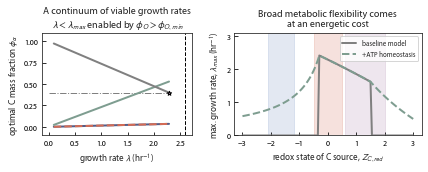

In [8]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6, 2.5), gridspec_kw=dict(width_ratios=[1, 1.25]))

# Estimate lambda_max from simple relationships
min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
est_lambda_max = 12*3600*g_ana*(1-min_phi_O)
lambda_max = phi_df.lambda_hr.max()
print('estimated lambda_max:', est_lambda_max)
print('actual lambda_max:', lambda_max)

plt.sca(axs[0])

# Line at min_phi_O
min_phi_O = 0.4
plt.plot([0, lambda_max], [min_phi_O, min_phi_O], 
         color='grey', ls='-.', lw=1)
#plt.text(1.1, min_phi_O+0.03, r'min. $\phi_O$', ha='center', fontsize=9)

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
cmap = dict(oxidation=colors['dark_blue'],
            reduction=colors['red'],
            anabolism=colors['dark_green'],
            other='grey')
processes = 'oxidation,reduction,anabolism'.split(',')
process_labels = dict(
    oxidation=r'$\phi_{ox}$',
    reduction=r'$\phi_{red}$',
    anabolism=r'$\phi_{ana}$',
    other=r'$\phi_O$')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    legend_label = process_labels[label]
    c = cmap[label]
    ls = '--' if label == 'reduction' else '-'
    plt.plot(x, phi_df[col], label=legend_label, color=c, ls=ls)
plt.scatter([lambda_max], [min_phi_O], color=colors['purple'], edgecolor='k', marker='*', zorder=10, s=20)

plt.axvline(est_lambda_max, color='k', ls='--', lw=1) 
#plt.text(est_lambda_max-0.02, 0.3, r'$\lambda_{max} \approx \gamma_{ana}(1-\phi_O)$', ha='right', va='center', rotation=90, fontsize=9)
plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'optimal C mass fraction $\phi_\alpha$')   
#plt.legend(loc=1)
plt.ylim(-0.1, 1.1)

plt.sca(axs[1])
phi_H_included = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == False]
no_phi_H = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey',
         label=r'baseline model'.format(min_phi_O))
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr,
         color=colors['dark_green'], ls='--',
         label=r'+ATP homeostasis', zorder=10)

plt.axvspan(-2.1, -1.2, color=colors['blue'], alpha=0.2, zorder=-10)
plt.axvspan(-0.5, 0.5, color=colors['red'], alpha=0.2, zorder=-10)
plt.axvspan(0.6, 2, color=colors['purple'], alpha=0.2, zorder=-10)

plt.legend(loc=1)
plt.ylim(0, 3.1)
plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.ylabel(r'max. growth rate, $\lambda_{max}$ (hr$^{-1}$)')

titles = [
    'A continuum of viable growth rates\n $\lambda < \lambda_{max}$ enabled by $\phi_O > \phi_{O,min}$',
    'Broad metabolic flexibility comes\nat an energetic cost',
]
for title, label, ax in zip(titles, 'ABC', axs):
    #ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_title(title)
    
plt.tight_layout()
plt.savefig('../output/Fig2.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

In [6]:
auto_var_zcred_df = pd.read_csv('../output/FigSX_autotrophy_ZCred.csv')
auto_var_zcred_df['lambda_hr,ZCorg'.split(',')]

,lambda_hr,ZCorg
0,0.000000,-2.00
1,0.000000,-1.95
2,0.000000,-1.90
3,0.000000,-1.85
4,0.000000,-1.80
...,...,...
76,0.068031,1.80
77,0.067500,1.85
78,0.066977,1.90
79,0.066462,1.95


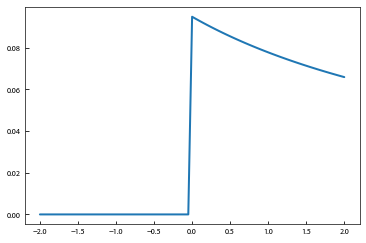

In [7]:
# Notice that organics need to be more oxidized than biomass
# otherwise you get e- from anabolism and have no where to 
# put them but into the synthesis of more organics. 
plt.plot(auto_var_zcred_df.ZCorg, auto_var_zcred_df.lambda_hr)

In [8]:

var_phi_O_df = pd.read_csv('../output/Fig2S1_variable_phi_O.csv')
var_phi_red_df = pd.read_csv('../output/Fig2S1_variable_phi_red.csv')
var_g_ana_df = pd.read_csv('../output/Fig2S1_variable_g_ana.csv')
var_g_red_df = pd.read_csv('../output/Fig2S1_variable_g_red.csv')


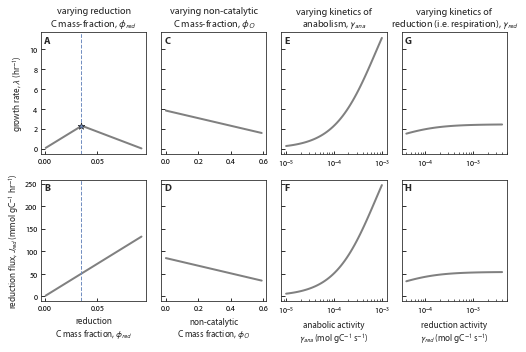

In [9]:
# Supplementary figure focusing on respiratory rates
# TODO: add variable stoichiometry, e.g. S4, to these panels
# TODO: calculate CUE and plot that as well
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(7.24, 5), sharey='row')
flat_axs = axs.flatten(order='F')

# Left panel: varying phi_red
# Model can use ATP homeostasis to maximize growth
plt.sca(axs[0,0])
max_idx = var_phi_red_df.lambda_hr.idxmax()
plt.plot(var_phi_red_df.reduction_phi, var_phi_red_df.lambda_hr, color='grey')
plt.scatter(var_phi_red_df.reduction_phi[max_idx], var_phi_red_df.lambda_hr[max_idx],
            color=colors['blue'], marker='*', zorder=10, s=50, edgecolor='k', lw=0.5)
plt.axvline(var_phi_red_df.reduction_phi[max_idx], color=colors['blue'], ls='--', lw=1)
plt.ylabel(r'growth rate, $\lambda$ (hr$^{-1}$)')
plt.title('varying reduction\nC mass-fraction, $\phi_{red}$')
plt.sca(axs[1,0])
plt.plot(var_phi_red_df.reduction_phi, var_phi_red_df.reduction_flux*3.6e6,
         color='grey')
plt.axvline(var_phi_red_df.reduction_phi[max_idx], color=colors['blue'], ls='--', lw=1)
plt.ylabel(r'reduction flux, $J_{red}$ (mmol gC$^{-1}$ hr$^{-1}$)')
plt.xlabel('reduction\nC mass fraction, $\phi_{red}$')

# Left panel: varying phi_O
# Model can use ATP homeostasis to maximize growth
plt.sca(axs[0,1])
plt.plot(var_phi_O_df.phi_O, var_phi_O_df.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying non-catalytic\nC mass-fraction, $\phi_O$')
plt.sca(axs[1,1])
plt.plot(var_phi_O_df.phi_O, var_phi_O_df.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('non-catalytic\nC mass fraction, $\phi_O$')

# Middle panels: varying anabolism gamma
# TODO: narrow range here so growth rates don't balloon as much
mask = var_g_ana_df['opt.max_phi_H_set'] == False
masked = var_g_ana_df[mask]

plt.sca(axs[0,2])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\nanabolism, $\gamma_{ana}$')
plt.sca(axs[1,2])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('anabolic activity\n$\gamma_{ana}$ (mol gC$^{-1}$ s$^{-1}$)')

# Right panels: varying anabolism gamma
mask = var_g_red_df['opt.max_phi_H_set'] == False
masked = var_g_red_df[mask]

plt.sca(axs[0, 3])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\n reduction (i.e. respiration), $\gamma_{red}$')
plt.sca(axs[1, 3])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('reduction activity\n$\gamma_{red}$ (mol gC$^{-1}$ s$^{-1}$)')

for label, ax in zip("ABCDEFGH", flat_axs):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('../output/Fig2S1_max_Jred.png', facecolor='white', bbox_inches='tight', dpi=300)

In [10]:
var_S4_df = pd.read_csv('../output/Fig3A_variable_ZCorg_var_S4.csv')
var_S3_df = pd.read_csv('../output/Fig3B_variable_ZCorg_var_S3.csv')
var_ZCB_df = pd.read_csv('../output/Fig3C_variable_ZCorg_var_ZCB.csv')

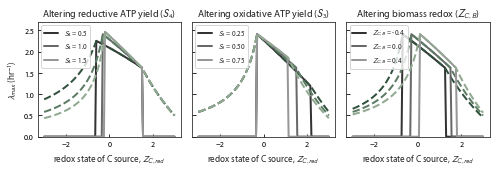

In [11]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(7, 2.5), sharey=True)
pal = sns.color_palette('Greys_r', n_colors=5)
greens = sns.color_palette('Greens_r', n_colors=5, desat=0.3)

# Variable S4 = respiratory ATP yield
plt.sca(axs[0])
plt.title('Altering reductive ATP yield ($S_4$)')

my_S4s = [0.5, 1, 1.5]
for i, S4 in enumerate(my_S4s):
    masked = var_S4_df[var_S4_df['S4'] == S4]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$S_4$ = {0:.1f}'.format(S4))
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=greens[i], ls='--')

plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.legend(loc=2)

# Variable S3 = oxidative ATP yield
plt.sca(axs[1])
plt.title('Altering oxidative ATP yield ($S_3$)')

my_S3s = [0.25, 0.5, 0.75]
for i, S3 in enumerate(my_S3s):
    masked = var_S3_df[var_S3_df['S3'] == S3]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$S_3$ = {0:.2f}'.format(S3+0))
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=greens[i], ls='--')

plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.legend(loc=2)

# Variable ZCB
plt.sca(axs[2])
plt.title('Altering biomass redox ($Z_{C,B}$)')

ZCBs = np.array(sorted(var_ZCB_df.ZCB.unique()))
my_ZCBs = ZCBs[[ 1, 5, 9, ]]
for i, zcb in enumerate(my_ZCBs):
    mask = var_ZCB_df['ZCB'] == zcb
    masked = var_ZCB_df[mask]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$Z_{{C,B}}$ = {0:.1f}'.format(zcb+1e-6))
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=greens[i], ls='--')

plt.legend(loc=2) 
plt.xlabel('redox state of C source, $Z_{C,red}$')  
plt.ylim(0, 2.7)

plt.tight_layout()
plt.savefig('../output/Fig2S2_change_stoich.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()